In [18]:
from PIL import Image
from indicnlp.tokenize import indic_tokenize
import numpy as np
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from collections import Counter

In [2]:
def load_telugu_captions(filepath):
    captions_dict = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t")
            img_name, caption = parts[0].split("#")[0], parts[1]
            if img_name not in captions_dict:
                captions_dict[img_name] = []
            captions_dict[img_name].append(caption)
    return captions_dict

# Convert text to Unicode IDs (Simple Tokenizer Workaround)
def text_to_ids(text):
    tokens = indic_tokenize.trivial_tokenize(text, lang='te')
    token_ids = [ord(char) for token in tokens for char in token]  # Unicode ID mapping
    return token_ids

In [14]:
from indicnlp.tokenize import indic_tokenize

class TeluguDataset:
    def __init__(self, df, tfms, vocab):
        self.df = df
        self.tfms = tfms
        self.vocab = vocab  # Dictionary mapping words to indices

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx, :]
        image_path = sample["image"]
        caption = sample["caption"]

        # Load and transform image
        image = Image.open(image_path).convert("RGB")
        image = np.array(image)
        image = self.tfms(image=image)["image"]

        # Process caption using IndicNLP tokenizer
        tokens = indic_tokenize.trivial_tokenize(caption, lang='te')  
        token_ids = [self.vocab.get(token, self.vocab["<unk>"]) for token in tokens]  

        # Add special tokens
        token_ids = [self.vocab["<s>"]] + token_ids + [self.vocab["</s>"]]

        labels = token_ids.copy()
        labels[:-1] = token_ids[1:]

        return image, token_ids, labels


In [19]:
def build_vocab(df, min_freq=2):
    word_freq = Counter()

    # Tokenize captions and count word occurrences
    for caption in df["caption"]:
        tokens = indic_tokenize.trivial_tokenize(caption, lang='te')
        word_freq.update(tokens)

    # Keep only words that appear at least `min_freq` times
    vocab_words = [word for word, freq in word_freq.items() if freq >= min_freq]

    # Create vocab mapping
    vocab = {word: idx for idx, word in enumerate(vocab_words, start=4)}

    # Add special tokens
    vocab["<pad>"] = 0
    vocab["<unk>"] = 1
    vocab["<s>"] = 2
    vocab["</s>"] = 3

    return vocab

In [20]:
vocab = build_vocab(df, min_freq=2)  # Adjust `min_freq` as needed
print("Vocabulary Size:", len(vocab))

Vocabulary Size: 8766


In [4]:
def collate_fn(batch):
    images = [i[0] for i in batch]
    input_ids = [i[1] for i in batch]
    labels = [i[2] for i in batch]

    images = torch.stack(images, dim=0)
    max_len = max(len(seq) for seq in input_ids)

    # Padding
    input_ids_padded = torch.full((len(batch), max_len), fill_value=0, dtype=torch.long)
    labels_padded = torch.full((len(batch), max_len), fill_value=-100, dtype=torch.long)

    for i, (inp, lbl) in enumerate(zip(input_ids, labels)):
        input_ids_padded[i, : len(inp)] = torch.tensor(inp, dtype=torch.long)
        labels_padded[i, : len(lbl)] = torch.tensor(lbl, dtype=torch.long)

    return images, input_ids_padded, labels_padded


In [15]:
caption_path = "D:/ict/Data/fl8telugu.txt"
telugu_captions = load_telugu_captions(caption_path)

# Convert to DataFrame
df = pd.DataFrame(
    [{"image": f"D:/ict/Data/Images/{img}", "caption": caption} for img, captions in telugu_captions.items() for caption in captions]
)

# Define Transformations
train_tfms = A.Compose([
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
    A.Resize(224, 224),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),
    ToTensorV2()
])


d:\ict\.venv\Lib\site-packages\albumentations\core\validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\TechMadmin\AppData\Local\Temp\ipykernel_14224\27032829.py:17: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], always_apply=True),


In [16]:
telugu_captions = load_telugu_captions("D:/ict/Data/fl8telugu.txt")

# Convert to DataFrame
df = pd.DataFrame([
    {"image": f"D:/ict/Data/Images/{img}", "caption": caption} 
    for img, captions in telugu_captions.items() 
    for caption in captions
])


In [21]:
dataset = TeluguDataset(df, train_tfms, vocab)

# Test Preprocessing
sample_image, sample_input_ids, sample_labels = dataset[0]

print("Sample Image Shape:", sample_image.shape)
print("Sample Token IDs:", sample_input_ids)
print("Sample Labels:", sample_labels)

Sample Image Shape: torch.Size([3, 224, 224])
Sample Token IDs: [2, 4, 5, 6, 7, 8, 1, 9, 10, 11, 12, 13, 14, 3]
Sample Labels: [4, 5, 6, 7, 8, 1, 9, 10, 11, 12, 13, 14, 3, 3]


In [23]:
idx_to_word = {idx: word for word, idx in vocab.items()}
tokens = [idx_to_word[idx] for idx in sample_input_ids]
print("Decoded Caption:", " ".join(tokens))


Decoded Caption: <s> గులాబీ రంగు దుస్తులు ధరించిన పిల్లవాడు <unk> మార్గంలో ఒక మెట్ల పైకి ఎక్కుతున్నాడు . </s>


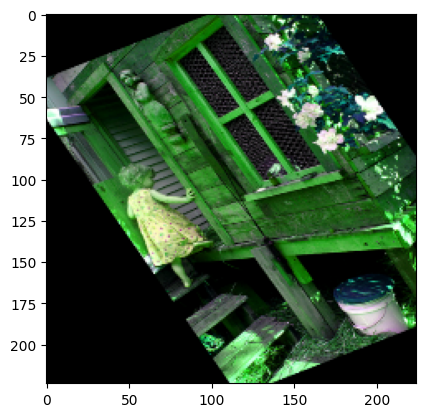

In [13]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

img = sample_image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
img = (img * 0.5) + 0.5  # De-normalize (assuming mean=0.5, std=0.5)
plt.imshow(img)
plt.show()
